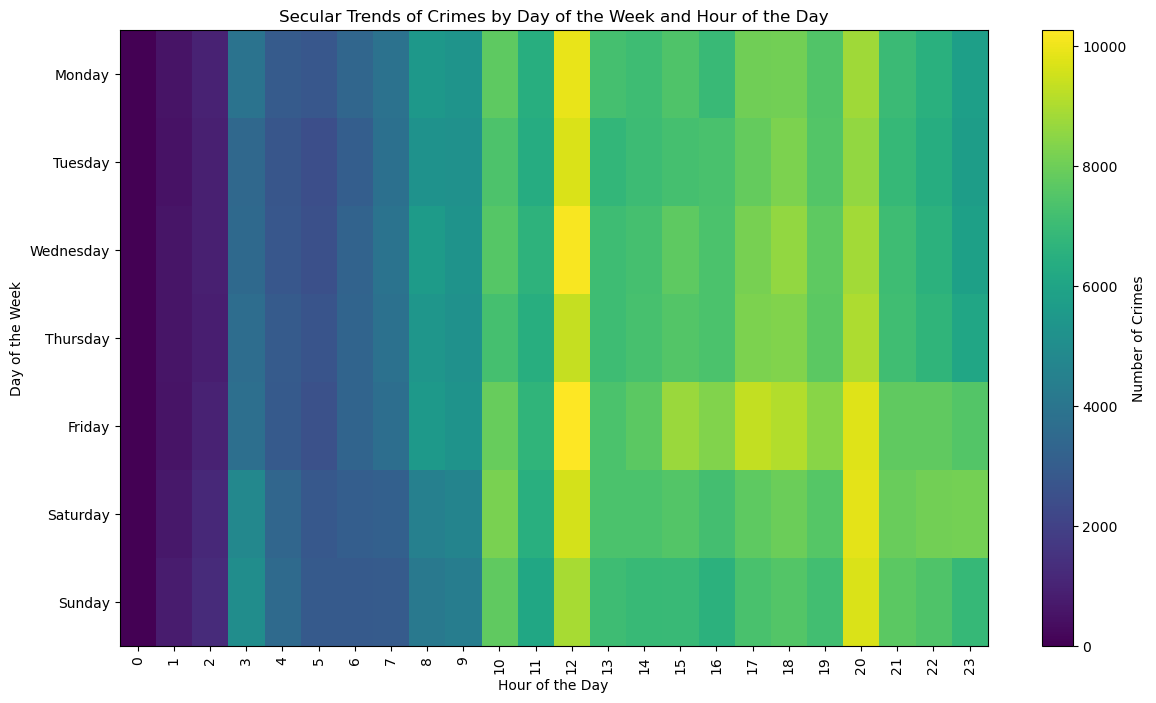

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and clean data
file_path = 'Crime_Data_from_2020_to_Present.csv'  # Update with your file path
crime_data = pd.read_csv(file_path)
# Convert 'TIME OCC' to hour format and 'DATE OCC' to datetime if not done earlier
crime_data['TIME OCC'] = pd.to_datetime(crime_data['TIME OCC'], format='%H%M', errors='coerce').dt.hour
crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'], errors='coerce')

# Add a 'Weekday' column to represent the day of the week
crime_data['Weekday'] = crime_data['DATE OCC'].dt.day_name()

# Group by weekday and hour to get crime counts
weekday_hourly_trends = crime_data.groupby(['Weekday', 'TIME OCC']).size().unstack(fill_value=0)
# Reindex weekdays to ensure they are in the correct order
weekday_hourly_trends = weekday_hourly_trends.reindex(["Monday", "Tuesday", "Wednesday", "Thursday", 
                                                       "Friday", "Saturday", "Sunday"])
# Ensure we have 24 columns for each hour
weekday_hourly_trends = weekday_hourly_trends.reindex(columns=np.arange(24), fill_value=0)

# Plot the heatmap
plt.figure(figsize=(14, 8))
plt.imshow(weekday_hourly_trends, aspect='auto', cmap='viridis', origin='upper')
plt.colorbar(label='Number of Crimes')
plt.xticks(ticks=np.arange(24), labels=weekday_hourly_trends.columns, rotation=90)
plt.yticks(ticks=np.arange(7), labels=weekday_hourly_trends.index)
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.title("Secular Trends of Crimes by Day of the Week and Hour of the Day")
plt.show()


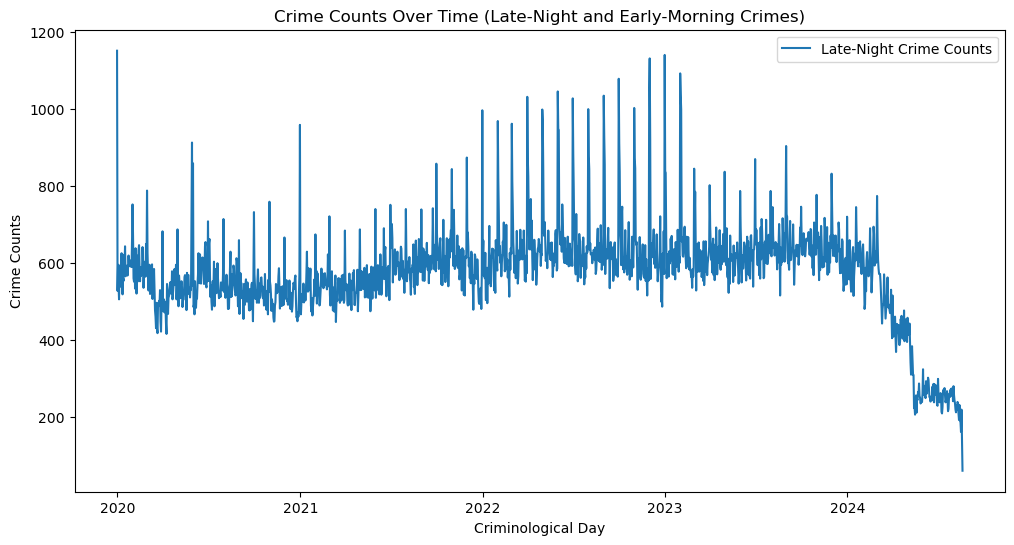

C:\Users\girid\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0117
Epoch 2/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0061
Epoch 3/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0041
Epoch 4/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0043
Epoch 5/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0043
Epoch 6/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0045
Epoch 7/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0050
Epoch 8/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0041
Epoch 9/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0042
Epoch 10/10
1686/1686 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0036
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


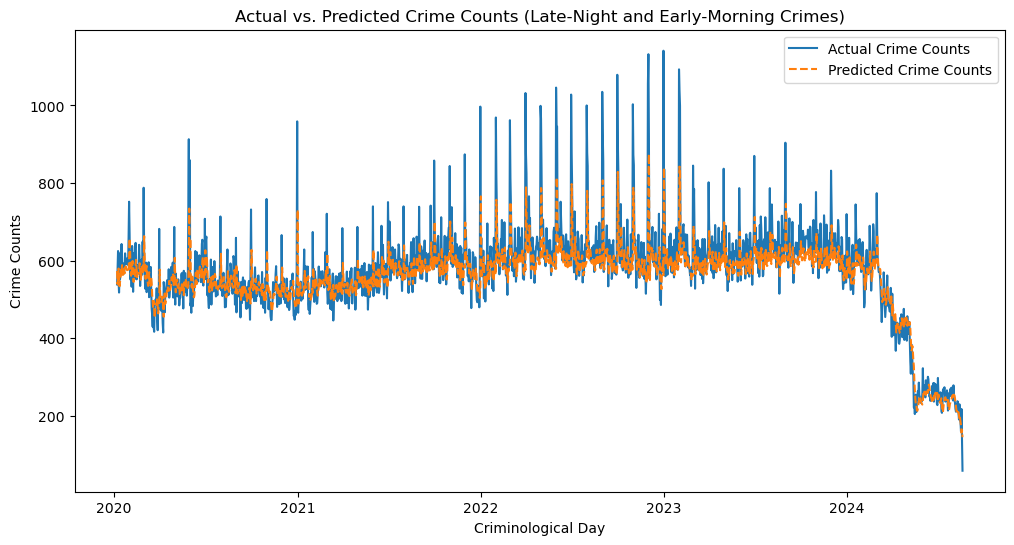

In [5]:

# Define a function to convert date and time to criminological day
def to_criminological_day(date, time):
    dt = datetime.strptime(f"{date} {time:04d}", "%Y-%m-%d %H%M")
    if dt.hour < 5:
        dt -= timedelta(days=1)
    return dt.replace(hour=5, minute=0, second=0)

# Clean 'TIME OCC' and 'DATE OCC' columns
crime_data['TIME OCC'] = crime_data['TIME OCC'].astype(str).str.extract('(\d{1,4})')[0].fillna('0000').astype(int).astype(str).str.zfill(4)
crime_data['DATE OCC'] = pd.to_datetime(crime_data['DATE OCC'], errors='coerce').dt.date

# Apply the criminological day transformation
crime_data['Criminological_Day'] = crime_data.apply(lambda row: to_criminological_day(row['DATE OCC'], int(row['TIME OCC'])), axis=1)

# Filter for late-night and early-morning crimes (10 PM - 5 AM)
crime_data['Hour'] = pd.to_datetime(crime_data['TIME OCC'], format='%H%M').dt.hour
late_night_crimes = crime_data[(crime_data['Hour'] >= 22) | (crime_data['Hour'] < 5)]

# Group by criminological day to count crimes
crime_counts = late_night_crimes.groupby('Criminological_Day').size().rename('Crime_Counts').reset_index()

# Plot initial time series of crime counts
plt.figure(figsize=(12, 6))
plt.plot(crime_counts['Criminological_Day'], crime_counts['Crime_Counts'], label='Late-Night Crime Counts')
plt.xlabel('Criminological Day')
plt.ylabel('Crime Counts')
plt.title('Crime Counts Over Time (Late-Night and Early-Morning Crimes)')
plt.legend()
plt.show()

# Scaling data for LSTM
scaler = MinMaxScaler()
crime_counts_scaled = scaler.fit_transform(crime_counts[['Crime_Counts']])

# Create sequences (X) and targets (y) for LSTM
window_size = 7
X, y = [], []
for i in range(window_size, len(crime_counts_scaled)):
    X.append(crime_counts_scaled[i - window_size:i, 0])
    y.append(crime_counts_scaled[i, 0])
X, y = np.array(X), np.array(y)

# Reshape for LSTM input
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=1, verbose=1)

# Predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Visualize the actual vs. predicted crime counts
plt.figure(figsize=(12, 6))
plt.plot(crime_counts['Criminological_Day'][window_size:], crime_counts['Crime_Counts'][window_size:], label='Actual Crime Counts')
plt.plot(crime_counts['Criminological_Day'][window_size:], predictions, label='Predicted Crime Counts', linestyle='--')
plt.xlabel('Criminological Day')
plt.ylabel('Crime Counts')
plt.title('Actual vs. Predicted Crime Counts (Late-Night and Early-Morning Crimes)')
plt.legend()
plt.show()
